In [75]:
##Demonstration for optimization of boundary conditions to minimize <dH/dx>, average variation in pressure head 
from allthethings import PyNetwork, PyPipe_ps
from allthethings import PyBC_opt_dh
import numpy as np
import matplotlib.pyplot as plt
from writeit import rewritePipes
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [76]:
##Set up initial conditions and various parameters. Three test cases (described in paper) are available below
case =1; #case =1,2, or 3. Corresponds to test cases (I), (II), and (III) from paper
Ds = [1.]*3  #pipe diameters
jt = [1,3,1,1] #junction types
bt = [1,1,1,1] #boundary types
bv = [0,0,0,0] #boundary values
r = [0,0,1,1]  #reflect 
ndof = 15    #degrees of freedom for optimization

#case (I)
if case==1:
    Ls = [100,100,25] #lengths
    Ns = [100,100,25] #number of grid cells
    T = 60.     #final time
    M = 7500.   #number of time steps
    dt = T/M
    a = 100
    h0s = [0,0,0]   #initial water heights in each pipe
    q0s = [0,0,0]   #initial discharge in each pipe
    Mrs = [0.015]*3  #manning roughness coeffs
    md = 0           #mode for interpolation (0 =Hermite)
    Q00 = 2.5*np.ones(M+1)  #time series for Q(x=0,t) for node being optimizaed over)
    Vin = dt*sum(Q00)  #inflow volume
    x0 = np.zeros(ndof)  
    for i in range((ndof-1)/2):
        x0[2*i+1]= Vin/T
#Case(II) and (III) differ only in a
if case >1:
    Ls = [100,100,50]
    Ns = [200,200,100]
    Mrs = [0.008]*3
    x0 = np.array([0.,0.,0.,0., 0.,0.,0.,0.,1.591549430918954,0.,0.530516476972984,0.,0.318309886183791,0.,0.227364204416993])
    if case==2:#Case(II)
        a = 10
        T = 120
        M = 4000
        Q00 = np.zeros(M+1)
        for i in range(M+1/2):
            Q00[i] = Vin/T
        h0s = [10,0,0]
        q0s = [5,0,0]
        md = 1
    elif case ==3:#Case(III)
        a =100
        T = 16
        M = 4000
        Vin = 20
        Q00 = np.zeros(M+1)
        for i in range(M+1/2):
            Q00[i] = Vin/T
        h0s = [10,0,0]
        q0s = [2.5,0,0]
        md = 1
        



In [77]:
fn = "indata/dhoptimization"  #base name of new .inp and .config files 
oldinp = "indata/better3pipes.inp" #old .inp file used to determine network connectivity
(fi, fc) = rewritePipes(fn,oldinp, Ns, Ls, Mrs, Ds, jt, bt, bv, r, h0s, q0s, T, M, a)
mtype =1
n0 = PyNetwork(fi, fc, mtype)
M = n0.M


new files are indata/dhoptimization.inp and indata/dhoptimization.config


In [78]:
dt = n0.T/n0.M
V0 = n0.getTotalVolume()#get initial volume
n0.setbVal(0,Q00)        #set boundary value time series at node 0 to Q00
n0.runForwardProblem(dt)  #solve up to time T
Vf = n0.getTotalVolume()  #get final volume


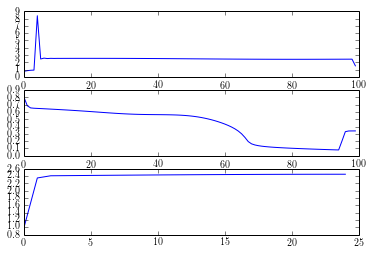

In [79]:
#plot the water height in each pipe at time T
hi = [n0.getHofA(i) for i in range(3)]
fig,ax = plt.subplots(nrows = n0.Nedges)
x00 = [0,0,0]
for k in range(n0.Nedges):
    x = np.arange(0,n0.Ls[k], n0.Ls[k]/n0.Ns[k])+x00[k]*np.ones(size(hi[k]))
    ax[k].plot(x,hi[k],'b')
dx = n0.Ls[0]/n0.Ns[0]

CFL = 0.800000 
space-average grad(H)
        Q = 0       reflecting
max  2.311769  
mean 16.888383  


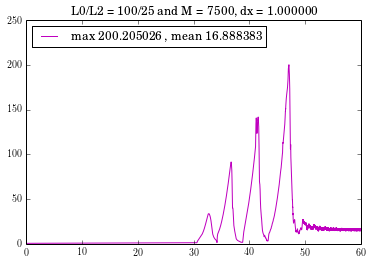

In [80]:
#plot the gradient pressure head at over time
print "CFL = %f " %(dt/dx*n0.a[0])
Hbar = [n0.getAveGradH(i) for i in range(n0.M+1)]
t = np.linspace(0,n0.T,n0.M+1)
kk = 1
plot(t,Hbar,'m')
legend(["max  %f  , mean %f" %(max(Hbar),mean(Hbar))], loc ='upper left')
#savefig("../../gradH_r66.pdf", format='pdf')
title("L0/L2 = %.f/%.f and M = %d, dx = %f"%(n0.Ls[0],n0.Ls[2], n0.M, n0.Ls[0]/n0.Ns[0]))
print "space-average grad(H)"
print "        Q = 0       reflecting"
print "max  %f  " %(max(Hbar)/sqrt(n0.M))
print "mean %f  " %(mean(Hbar))
dx = n0.Ls[0]/n0.Ns[0]


In [81]:
def idx_t(i,j,n,N):
    return (2*(N+2)*n+(N+2)*i+j)

In [82]:
Af = np.pi/4.
wn=0;#which node you're optimizing the boundary time series for
opt1 = PyBC_opt_dh(fi, fc, ndof, x0, wn, Vin, md)#set up instance of optimization class
Q0orig = opt1.getBCtimeseries()
opt1.compute_f()
f0 = opt1.f
print "f is %f" %f0
print "T is %f" %opt1.T
print "Using %s modes" %opt1.modetype


f is 63423.765722
T is 60.000000
Using Hermite modes


In [83]:
Vin2 = np.trapz(Q0orig, x=t)
print "Vin (specified) = %f" %Vin
print "Vin (acutal) = %f" %Vin2




Vin (specified) = 150.020000
Vin (acutal) = 150.020000


In [21]:
#solve!
opt1.solve()

In [72]:
print "f is %f" %opt1.f
ff = opt1.f
xf = opt1.x
print "Improvement f_0/f_f is %f" %(ff/f0)
print "components of x_f are\n i    x_i\n******************"
for i in range(len(opt1.x)):
    print "%2d    %f "%(i+1,xf[i]) 

f is 19093.276199
Improvement f_0/f_f is 0.301043
components of x_f are
 i    x_i
******************
 1    -0.000057 
 2    2.500304 
 3    0.000117 
 4    2.500208 
 5    0.000022 
 6    2.500301 
 7    -0.000032 
 8    2.500269 
 9    -0.000068 
10    2.500347 
11    0.000331 
12    2.499945 
13    -0.000015 
14    0.830880 
15    2.337414 


In [65]:
#make a place to put the data
import os
lucky = 1e6  #you feeling lucky today pal? use this to use include a random number in filename to ensure you don't write over old data
kk = np.int(lucky*np.random.rand())
where = "../results_ndof%d_wavespeed_%03.f_improvement_%f/"%(ndof,n0.a[0],ff/f0)
if not os.path.exists(where):
    os.makedirs(where)

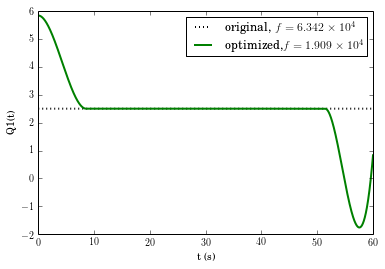

In [60]:
#plot the boundary time series before and after optimization
rc('text', usetex=True)
rc('font', family='serif')
ff = opt1.f
Q01 = opt1.getBCtimeseries()
t = np.linspace(0,opt1.T, opt1.M+1)
fig,ax = plt.subplots(nrows = 1)
ax.plot(t,Q0orig,'k:', linewidth = 2)#,t,np.zeros(opt1.M+1),'r')
ax.plot(t,Q01,'g', linewidth = 2)
ax.set_ylabel('Q1(t)')
s0 = "%.3e"%f0
sf = "%.3e"%ff
w0 = s0.find('e')
wf = sf.find('e')
p0 = int(s0[w0+2:])
pf = int(sf[wf+2:])
legend([r'original, $f = %s\times10^%1.d$'%(s0[0:w0],p0), r'optimized,$f = %s\times10^%1.d$'%(sf[0:wf],pf)], loc = 'upper right')
ax.set_xlabel('t (s)')

savefig(where+"opt_dh_Qblahnod%d.eps"%ndof, format='eps')

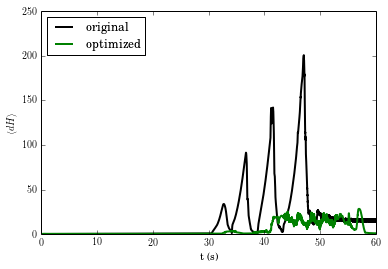

In [61]:
#plot <dH/dx> as a function of time for each bc time series
n2 = PyNetwork(fi, fc, mtype)
n3 = PyNetwork(fi,fc, mtype)
n2.setbVal(0,Q0orig)
n3.setbVal(0,Q01)
n2.runForwardProblem(dt)
n3.runForwardProblem(dt)
xf = opt1.x
Hbar2 = [n2.getAveGradH(i) for i in range(n0.M+1)]
Hbar3 = [n3.getAveGradH(i) for i in range(n0.M+1)]
plot(t,Hbar2, 'k', t,Hbar3,'g', linewidth=2)
ax = gca()
legend(['original', 'optimized'], loc = 'upper left')
ax.set_xlabel('t (s)')
ax.set_ylabel(r"$\langle dH \rangle$")
savefig(where+"opt_dh_dhblahnodf%d.eps"%ndof, format='eps')

In [62]:
#save results to a labeled folder 
with open(where+"more_info.txt",'w') as fout:
    fout.write("data (Q0, Qf) pickled to Q0.p and Qf.p\n\n")
    fout.write("to generate whole history, load them and run:\n\
                n0 = PyNetwork(fi,fc, 1)\n\
                n0.setbVal(0,Q)\n\
                n0.runForwardProblem(dt)\n\
                for Q = Q00 or Q = Qf\n\n")
    fout.write("***************************************************************\n")
    fout.write( "interpolation   CPU solve t  actual solve t    f0             ff            ff/f0      Vin   \n")  
    fout.write( "%s         %.2f    %.2f     %e     %e    %.5f   %.2f\n"%(opt1.modetype,opt1.solve_t, opt1.wsolve_t,f0, ff, ff/f0, Vin))
    fout.write("***************************************************************\n")
    fout.write("x0                   xf\n")
    for i in range(len(x0)):
        fout.write("%.15f    %.15f\n"%(x0[i],xf[i]))
import shutil
shutil.copy(fi,where)
shutil.copy(fc,where)
import pickle
pickle.dump(Q00, open(where+"Q0.p", "wb"))
pickle.dump(Q01, open(where+"Qf.p", "wb"))
print "results saved to %s"%where

results saved to ../results_ndof15_wavespeed_100_improvement_0.301043/


In [64]:
print "CPU solve t  actual solve t    ff/f0"  
print " %.2f         %.2f         %.5f"%(opt1.solve_t, opt1.wsolve_t,ff/f0)

CPU solve t  actual solve t    ff/f0
 2552.39         484.42         0.30104
